##### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Video Inbetweening using 3D Convolutions


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/tweening_conv3d"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tweening_conv3d.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/tweening_conv3d.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/tweening_conv3d.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/tweening_conv3d_bair/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

Yunpeng Li, Dominik Roblek, and Marco Tagliasacchi. From Here to There: Video Inbetweening Using Direct 3D Convolutions, 2019.

https://arxiv.org/abs/1905.10240


Current Hub characteristics:
- has models for BAIR Robot pushing videos and KTH action video dataset (though this colab uses only BAIR)
- BAIR dataset already available in Hub. However, KTH videos need to be supplied by the users themselves.
- only evaluation (video generation) for now
- batch size and frame size are hard-coded


## Setup

Since `tfds.load('bair_robot_pushing_small', split='test')` would download a 30GB archive that also contains the training data, we download a separated archive that only contains the 190MB test data. The used dataset has been published by [this paper](https://arxiv.org/abs/1710.05268) and is licensed as Creative Commons BY 4.0.

In [2]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow_datasets.core import SplitGenerator
from tensorflow_datasets.video.bair_robot_pushing import BairRobotPushingSmall

import tempfile
import pathlib

TEST_DIR = pathlib.Path(tempfile.mkdtemp()) / "bair_robot_pushing_small/softmotion30_44k/test/"

In [3]:
# Download the test split to $TEST_DIR
!mkdir -p $TEST_DIR
!wget -nv https://storage.googleapis.com/download.tensorflow.org/data/bair_test_traj_0_to_255.tfrecords -O $TEST_DIR/traj_0_to_255.tfrecords

2020-11-15 17:52:45 URL:https://storage.googleapis.com/download.tensorflow.org/data/bair_test_traj_0_to_255.tfrecords [189852160/189852160] -> "/tmp/tmpxbg68o0d/bair_robot_pushing_small/softmotion30_44k/test/traj_0_to_255.tfrecords" [1]


In [4]:
# Since the dataset builder expects the train and test split to be downloaded,
# patch it so it only expects the test data to be available
builder = BairRobotPushingSmall()
test_generator = SplitGenerator(name='test', gen_kwargs={"filedir": str(TEST_DIR)})
builder._split_generators = lambda _: [test_generator]
builder.download_and_prepare()

## BAIR: Demo based on numpy array inputs

In [5]:
# @title Load some example data (BAIR).
batch_size = 16

# If unable to download the dataset automatically due to "not enough disk space", please download manually to Google Drive and
# load using tf.data.TFRecordDataset.
ds = builder.as_dataset(split="test")
test_videos = ds.batch(batch_size)
first_batch = next(iter(test_videos))
input_frames = first_batch['image_aux1'][:, ::15]
input_frames = tf.cast(input_frames, tf.float32)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))


Test videos shape [batch_size, start/end frame, height, width, num_channels]:  (16, 2, 64, 64, 3)


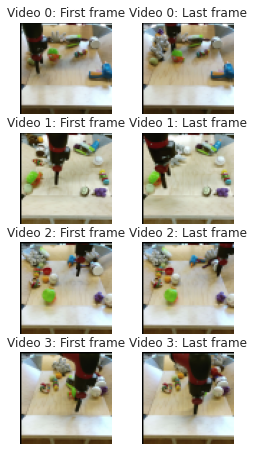

In [6]:
# @title Visualize loaded videos start and end frames.

print('Test videos shape [batch_size, start/end frame, height, width, num_channels]: ', input_frames.shape)
sns.set_style('white')
plt.figure(figsize=(4, 2*batch_size))

for i in range(batch_size)[:4]:
  plt.subplot(batch_size, 2, 1 + 2*i)
  plt.imshow(input_frames[i, 0] / 255.0)
  plt.title('Video {}: First frame'.format(i))
  plt.axis('off')
  plt.subplot(batch_size, 2, 2 + 2*i)
  plt.imshow(input_frames[i, 1] / 255.0)
  plt.title('Video {}: Last frame'.format(i))
  plt.axis('off')

### Load Hub Module

In [7]:
hub_handle = 'https://tfhub.dev/google/tweening_conv3d_bair/1'
module = hub.load(hub_handle).signatures['default']

### Generate and show the videos

In [8]:
filled_frames = module(input_frames)['default'] / 255.0

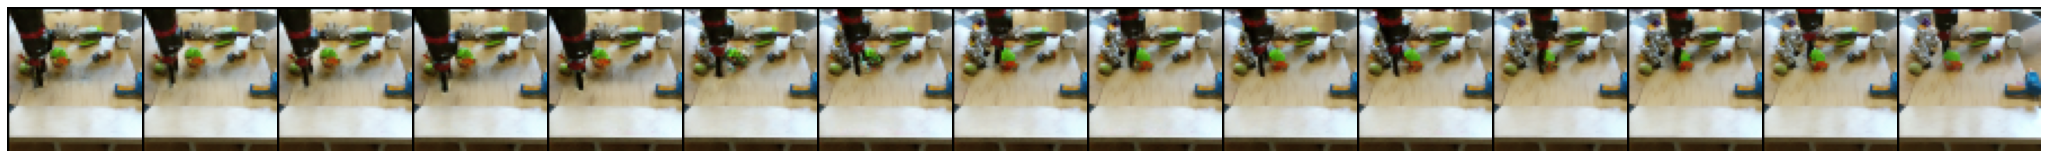

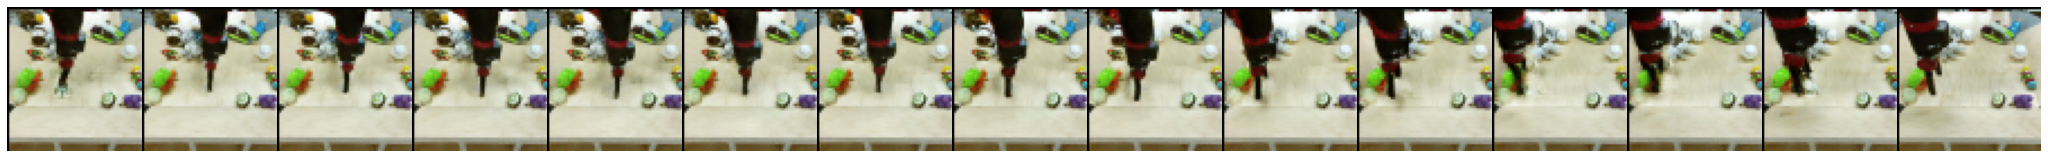

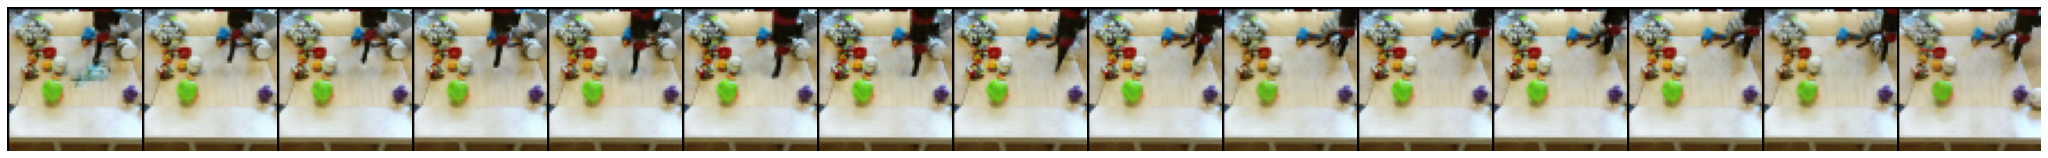

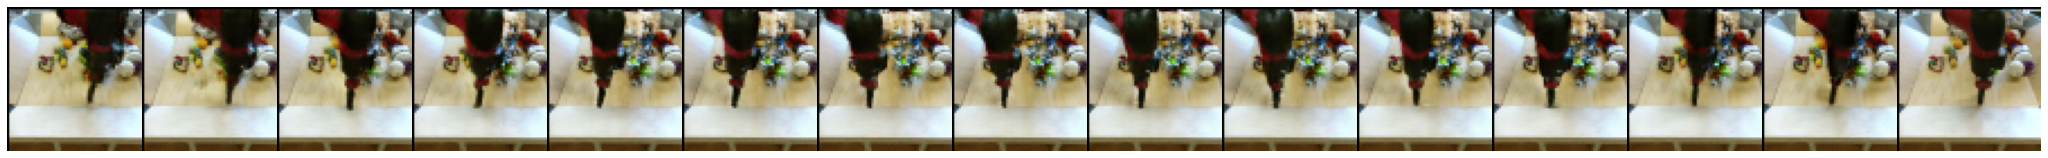

In [9]:
# Show sequences of generated video frames.

# Concatenate start/end frames and the generated filled frames for the new videos.
generated_videos = np.concatenate([input_frames[:, :1] / 255.0, filled_frames, input_frames[:, 1:] / 255.0], axis=1)

for video_id in range(4):
  fig = plt.figure(figsize=(10 * 2, 2))
  for frame_id in range(1, 16):
    ax = fig.add_axes([frame_id * 1 / 16., 0, (frame_id + 1) * 1 / 16., 1],
                      xmargin=0, ymargin=0)
    ax.imshow(generated_videos[video_id, frame_id])
    ax.axis('off')

### image_aux1

In [37]:
from utils import *
from collections import defaultdict

path = './dataset/BAIR/'
originals = []
generated = []
interpolated = []
stats_inter = []
stats_gen = []

i = 'image_aux1'
n = 0
for x in test_videos:
    print(n)
    n += 1
    batch = x[i]

    input_frames = batch[:, ::15]
    input_frames = tf.cast(input_frames, tf.float32)
    filled_frames = module(input_frames)['default']

    generated_videos = np.concatenate([input_frames[:, :1] , filled_frames, input_frames[:, 1:]], axis=1)

    for idx in range(batch_size):
        data_interpolated = generate_resized_and_interpolated_video(batch[idx][:16], input_frames[idx], True)

        original = batch[idx][:16]

        originals.append(original.numpy())
        generated.append(generated_videos[idx])
        interpolated.append(data_interpolated)
        
        for frame in range(16):
            imageio.imwrite(path+'original/' +str(n) +"_"+ i+"_"+str(idx)+"_"+str(frame)+".png",original.numpy()[frame])
            imageio.imwrite(path+'interpolate/'+str(n) +"_"+ i +"_"+str(idx)+"_"+str(frame)+".png",data_interpolated[frame])
            imageio.imwrite(path+'generate/' +str(n) +"_"+ i +"_"+str(idx)+"_"+str(frame)+".png",generated_videos[idx][frame])

        stats_gen.append(L2Difference(original, generated_videos[idx]))
        stats_inter.append(L2Difference(original, data_interpolated))

0


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


In [38]:
print(i, "avg interpolated L2 dist = {} ".format(np.mean(stats_inter)))
print(i, "SD of interpolated L2 dist = {} ".format(np.std(stats_inter)))

print(i, "avg generated L2 dist = {} ".format(np.mean(stats_gen)))
print(i, "SD of generated L2 dist = {} ".format(np.std(stats_gen)))

image_aux1 avg interpolated L2 dist = 2317.8828900821118 
image_aux1 SD of interpolated L2 dist = 388.43364043404523 
image_aux1 avg generated L2 dist = 2892.0167048216854 
image_aux1 SD of generated L2 dist = 266.966451194845 


In [13]:
# coding=utf-8
# Copyright 2020 The Google Research Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Example code that computes FVD for some empty frames.
The FVD for this setup should be around 131.
"""

# from __future__ import absolute_import
# from __future__ import division
# from __future__ import print_function

import tensorflow.compat.v1 as tfv1
import frechet_video_distance as fvd

# Number of videos must be divisible by 16.
NUMBER_OF_VIDEOS = len(originals)
VIDEO_LENGTH = 15
batch_size = 16

def loop(idx):
      
      result_inter = 0 
      result_gen  = 0 
      with tfv1.Graph().as_default():

        video_set1 = tfv1.convert_to_tensor(np.array(originals[idx*batch_size:(idx+1)*batch_size]))
        video_set2 = tfv1.convert_to_tensor(np.array(interpolated[idx*batch_size:(idx+1)*batch_size]))
        video_set3 = tfv1.convert_to_tensor(np.array(generated[idx*batch_size:(idx+1)*batch_size]))

        first_set_of_videos = tfv1.convert_to_tensor(video_set1)
        second_set_of_videos = tfv1.convert_to_tensor(video_set2)
        third_set_of_videos = tfv1.convert_to_tensor(video_set3)
    #     first_set_of_videos = tf.zeros([NUMBER_OF_VIDEOS, VIDEO_LENGTH, 64, 64, 3])


        result_inter = fvd.calculate_fvd(
            fvd.create_id3_embedding(fvd.preprocess(first_set_of_videos,
                                                    (224, 224))),
            fvd.create_id3_embedding(fvd.preprocess(second_set_of_videos,
                                                    (224, 224))))
        result_gen = fvd.calculate_fvd(
            fvd.create_id3_embedding(fvd.preprocess(first_set_of_videos,
                                                    (224, 224))),
            fvd.create_id3_embedding(fvd.preprocess(third_set_of_videos,
                                                    (224, 224))))

        with tfv1.Session() as sess:
            tfv1.enable_eager_execution(); 
            sess.run(tfv1.global_variables_initializer())
            sess.run(tfv1.tables_initializer())
            print("FVD is: %.2f." % sess.run(result_inter))
            print("FVD is: %.2f." % sess.run(result_gen))
        return result_inter, result_gen


In [14]:
inter, gen = loop(0)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


FVD is: 797.93.
FVD is: 657.18.


In [15]:
inter, gen = loop(1)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


FVD is: 912.57.
FVD is: 708.28.


In [16]:
inter, gen = loop(2)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


FVD is: 772.54.
FVD is: 585.23.


In [ ]:
inter, gen = loop(3)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


FVD is: 766.38.


In [30]:
3249.42 / 4

812.355

In [31]:
1950.69 / 3

650.23